<a href="https://colab.research.google.com/github/barbinanm/AlfaBank/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = pd.read_excel('default_of_credit_card_clients.xlsx', index_col=0, header=1, sheet_name='Data')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
X = df.iloc[:, 0:22]
y = df.iloc[:, 23].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('train size:', len(X_train), ', test size:', len(X_test))

train size: 24000 , test size: 6000


Обучаем модель и получаем предсказания

In [ ]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, max_features ='sqrt', random_state=42)
tree.fit(X_train, y_train)
train_pred = tree.predict_proba(X_train)[:, 1]
test_pred = tree.predict_proba(X_test)[:, 1]

Посмотрим, какие факторы используются в модели

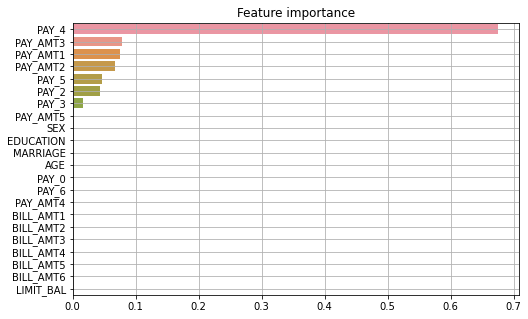

In [ ]:
order = tree.feature_importances_.argsort()[::-1]
plt.figure(figsize=(8, 5))
sns.barplot(x=tree.feature_importances_[order], y=X.columns[order], orient='h')
plt.title('Feature importance')
plt.grid()
plt.show()

Как видим, модель использует только факторы, связанные с историей платежей заемщиков

In [ ]:
def get_auc_curve(y_true, y_pred):
    auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    return auc_score, fpr, tpr

Посмотрим на качество и стабильность модели

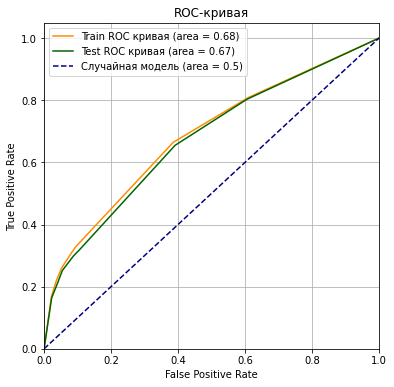

In [ ]:
plt.figure(figsize=(6, 6))

roc_auc, fpr, tpr = get_auc_curve(y_train, train_pred)
plt.plot(fpr, tpr, color='darkorange',
         label='Train ROC кривая (area = %0.2f)' % roc_auc)

roc_auc, fpr, tpr = get_auc_curve(y_test, test_pred)
plt.plot(fpr, tpr, color='darkgreen',
         label='Test ROC кривая (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Случайная модель (area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid()
plt.show()

Качество модели высокое, метрики на обучении и тесте не отличаются - модель стабильна

Визуализируем дерево решений, для этого потребуется установить библиотеки `graphviz` и `pydotplus`

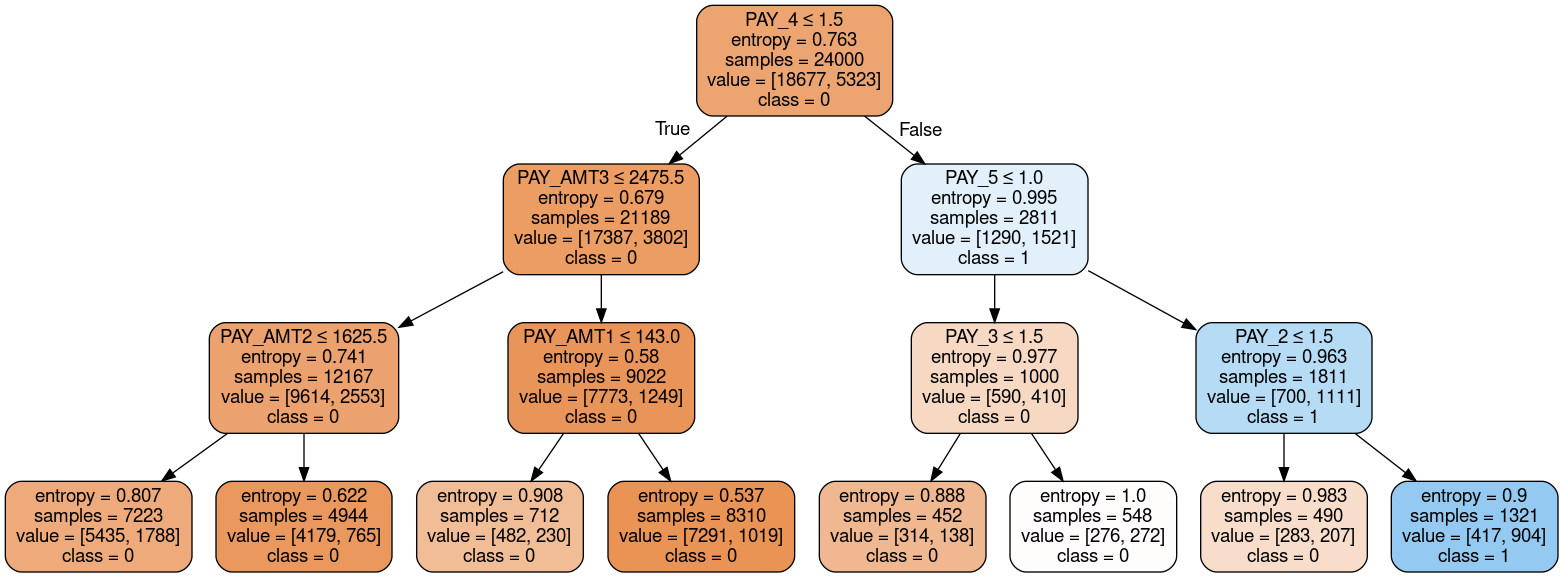

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus
feature_cols = list(X.columns)
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())